# exmachina example

Please follow install instruction in README.md for preparation to download <i>k</i>NN index and data.

In this example, the query is SCOP domain `d1qg3a1` and the template is `d1va9a1`.

* `d1qg3a1` (https://scop.berkeley.edu/sunid=21993&ver=1.75)
  * b.1.2.1 Integrin beta-4 subunit {Human (Homo sapiens) [TaxId: 9606]}
* `d1va9a1` (https://scop.berkeley.edu/sunid=119904&ver=1.75)
  * b.1.2.1 Down syndrome cell adhesion molecule-like protein 1, DSCAML1 {Human (Homo sapiens) [TaxId: 9606]}

You can download example PSSMs of query and template protein domains.

In [ ]:
%%bash
mkdir -p pssm/{qg,va}
wget -O pssm/qg/d1qg3a1.mtx http://www.cb.cs.titech.ac.jp/~makigaki/machina/data/pssm/qg/d1qg3a1.mtx
wget -O pssm/va/d1va9a1.mtx http://www.cb.cs.titech.ac.jp/~makigaki/machina/data/pssm/va/d1va9a1.mtx

These PSSMs were generated by three-iteration PSI-BLAST searching into Uniref90.

```bash
psiblast -query <query_fasta> \
         -db <uniref90_dir> \
         -num_iterations 3 \
         -out_ascii_pssm data/pssm/{query_id[2:3]}/<query_id>.mtx \
         -save_pssm_after_last_round
```

Please note that machina requires ASCII formatted PSSM and the out directory is not so frexible.

## Predict substitution score

This consumes 23GB RAM.

In [1]:
from machina.predict import predict_scores

query = 'd1qg3a1'
template = 'd1va9a1'
predict_scores(query, template)

100%|██████████| 1/1 [00:05<00:00,  5.19s/it]
2019-04-20 23:41:57,313 [INFO] 
2019-04-20 23:41:57,314 [INFO] Result is saved into: results/d1qg3a1/d1va9a1.npy


## Generate pairwise alignments

In [8]:
from pathlib import Path

import numpy as np

from machina.generate_alignment import alignment_local

GAP_OPEN = -0.1
GAP_EXTEND = -0.0001

_, ali = alignment_local(f'results/{query}/{template}.npy', query, template, 'pssm', GAP_OPEN, GAP_EXTEND)
np.save(f'results/{query}/alignment_{template}.npy', np.array(ali))

## Make models

Install MODELLER to make models and download template PDB.

In [ ]:
%%bash
mkdir -p results/d1qg3a1/pdb
wget -O results/d1qg3a1/pdb/d1va9a1.ent http://www.cb.cs.titech.ac.jp/~makigaki/machina/data/scop_e/va/d1va9a1.ent

In [9]:
from machina.generate_models import MachinaModel


MachinaModel().generate_protein_model(
    query, template,
    f'results/{query}/alignment_{template}.npy',
    f'results/{query}',
    f'results/{query}/pdb')

## Visualize

-------DLGAPQNPNAKAAGSRKIHFNWLPPS-----GKPMGYRVKYWIQGD-SESEAHLLDSKV----PSVELTNLYPYCDYEMKVCAYGAQGEGPYSSLVSCRTHQ
ISTEEAAPDGPPMDVTLQPVTSQSIQVTWKAPKKELQNGVIRGYQIGYRENSPGSNGQYSIVEMKATGDSEVYTLDNLKKFAQYGVVVQAFNRAGTGPSSSEINATTLE


[None, None]

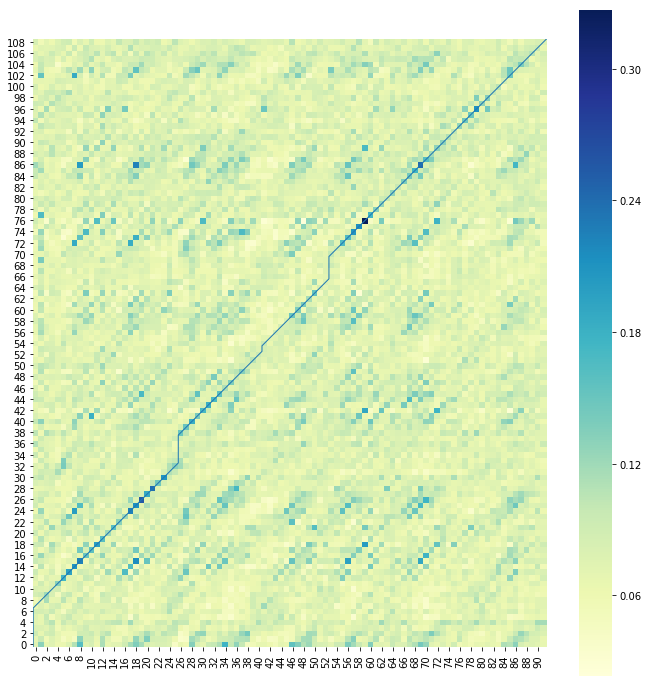

In [11]:
%matplotlib inline

from Bio import SeqIO
from Bio.Align import MultipleSeqAlignment
from matplotlib import pyplot
import seaborn as sns
from IPython.display import display


def alignment_graph(alignment):
    assert len(alignment[0]) == len(alignment[1])
    x, y = [0], [0]
    for i in range(len(alignment[0])):
        if alignment[0][i] == '-':
            x.append(x[-1])
            y.append(y[-1] + 1)
        elif alignment[1][i] == '-':
            x.append(x[-1] + 1)
            y.append(y[-1])
        else:
            x.append(x[-1] + 1)
            y.append(y[-1] + 1)
    return np.array(x), np.array(y)

labels = np.load(f'results/{query}/{template}.npy')
index = list(SeqIO.parse(f'results/{query}/{template}.pir', 'pir'))
x, y = alignment_graph(MultipleSeqAlignment(index))

fig, ax = pyplot.subplots(figsize=(labels.shape[0]/8, labels.shape[1]/8))
sns.heatmap(labels.T, ax=ax, linewidths=0, square=True, rasterized=True, cmap="YlGnBu", cbar_kws={"shrink": 0.9}).invert_yaxis()
ax.plot(x, y, linewidth=1)
display([print(_.seq) for _ in index])

Native structure is available for comparison.

In [ ]:
%%bash
mkdir -p results/d1qg3a1/pdb
wget -O results/d1qg3a1/pdb/d1qg3a1.ent http://www.cb.cs.titech.ac.jp/~makigaki/machina/data/scop_e/qg/d1qg3a1.ent

In [13]:
import nglview

nglview.show_file('results/d1qg3a1/d1va9a1.pdb')

NGLWidget()

In [14]:
nglview.show_file('results/d1qg3a1/pdb/d1qg3a1.ent')

NGLWidget()